# Revenue Modeling: BIRT

**Purpose:** For the tax revenue of interest, explore forecasts, testing out different combinations of 
endog and exog variables.

Once the best fit is determined, we can plug the parameters into the main "parameters.yml" file and run reproducible model fits through the command line using `fyp-analysis run`.

In [22]:
TAX_NAME = "BIRT"
TAX_BASE_COLUMN = f"{TAX_NAME}Base"

## Software Setup

If changes are made to the analysis code, run the below cell to reload the changes:

In [23]:
%reload_kedro

2022-07-08 12:06:27,902 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/nicholashand/LocalWork/Analysis/five-year-plan-analysis
2022-07-08 12:06:28,308 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-07-08 12:06:28,396 - kedro.extras.extensions.ipython - INFO - ** Kedro project Five Year Plan Analysis
2022-07-08 12:06:28,397 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


Imports:

In [24]:
# Base imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from phila_style.matplotlib import get_theme

# Prediction functions
from fyp_analysis.pipelines.modeling.predict import (
    get_possible_endog_variables,
    run_possible_models,
    fit_var_model,
    plot_forecast_results,
    plot_projection_comparison,
    aggregate_to_fiscal_year,
    get_forecasts_from_fits,
)

# The main preprocess pipeline
from fyp_analysis.pipelines.data_processing.preprocess import PreprocessPipeline
from fyp_analysis.extras.datasets import load_cbo_data, Taxes

In [25]:
pd.options.display.max_columns = 999

## Parameter Setup

Set up the data catalog. We can use `DATA.load()` to load specific data instances.

In [26]:
DATA = context.catalog

Available data:

In [27]:
DATA.list()

['economic_indicators',
 'quarterly_features_raw',
 'quarterly_features_cbo_imputed',
 'features_and_bases',
 'features_and_bases_sa',
 'stationary_guide',
 'final_unscaled_features',
 'final_scaled_features',
 'scaled_feature_correlations',
 'grangers_matrix',
 'possible_endog_variables',
 'plan_details',
 'wage_fit_params',
 'sales_fit_params',
 'net_income_fit_params',
 'gross_receipts_fit_params',
 'rtt_fit_params',
 'parking_fit_params',
 'amusement_fit_params',
 'npt_fit_params',
 'tax_base_forecasts',
 'tax_revenue_forecasts',
 'parameters',
 'params:fresh_indicators',
 'params:seasonal_adjustments',
 'params:min_feature_year',
 'params:max_fit_date',
 'params:grangers_maxlag',
 'params:grangers_max_date',
 'params:plan_start_year',
 'params:cbo_forecast_date']

Load the parameter dict too:

In [28]:
PARAMS = context.params

In [29]:
PARAMS

{'fresh_indicators': False,
 'seasonal_adjustments': ['ActivityLicensesPhilly',
  'BizLicensesPhilly',
  'BuildingPermitsPhilly',
  'CPIPhillyMSA',
  'ContinuedClaimsPA',
  'WeeklyEconomicIndex',
  'DeedTransfersPhilly',
  'InitialClaimsPA',
  'UncertaintyIndex',
  'UnemploymentPhilly'],
 'min_feature_year': 1996,
 'max_fit_date': '2022-06-30',
 'grangers_maxlag': 6,
 'grangers_max_date': '2019-12-31',
 'plan_start_year': 2023,
 'cbo_forecast_date': 'latest'}

Extract specific parameters:

In [30]:
# Trim features to this start year
min_year = PARAMS["min_feature_year"]

# When is the CBO forecast from?
cbo_forecast_date = PARAMS["cbo_forecast_date"]

# First fiscal year of the plan
plan_start_year = PARAMS["plan_start_year"]

## Data Setup

Load taxes object responsible for loading historical tax data"

In [31]:
# Load the Plan details we are using
plan_details = DATA.load("plan_details")

# All taxes
all_taxes = Taxes(plan_details)

# This tax
this_tax = all_taxes[TAX_NAME]

2022-07-08 12:06:28,520 - kedro.io.data_catalog - INFO - Loading data from `plan_details` (PlanDetailsYAMLDataSet)...


/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/desert/_make.py:300: RemovedInMarshmallow4Warning: The 'default' attribute of fields is deprecated. Use 'dump_default' instead.
  if field.default == field.missing == default == marshmallow.missing:
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/desert/_make.py:300: RemovedInMarshmallow4Warning: The 'missing' attribute of fields is deprecated. Use 'load_default' instead.
  if field.default == field.missing == default == marshmallow.missing:


Data associated with a tax is stored in the `.data` attribute:

In [32]:
this_tax.data.head()

,fiscal_quarter,fiscal_year,BIRTRevenue,rate_gross_receipts,rate_net_income,net_income_fraction,gross_receipts_fraction,GrossReceiptsRevenue,GrossReceiptsBase,NetIncomeRevenue,NetIncomeBase
0,1,1996,1.960472e+07,0.0300,0.065,0.69,0.31,6.077464e+06,2.025821e+08,1.352726e+07,2.081117e+08
1,2,1996,1.238151e+07,0.0300,0.065,0.69,0.31,3.838269e+06,1.279423e+08,8.543243e+06,1.314345e+08
2,3,1996,2.117193e+07,0.0300,0.065,0.69,0.31,6.563298e+06,2.187766e+08,1.460863e+07,2.247482e+08
3,4,1996,1.736380e+08,0.0300,0.065,0.69,0.31,5.382777e+07,1.794259e+09,1.198102e+08,1.843234e+09
4,1,1997,1.297096e+07,0.0295,0.065,0.69,0.31,4.020999e+06,1.363051e+08,8.949966e+06,1.376918e+08


Load the final unscaled features:

In [33]:
unscaled_features = DATA.load("final_unscaled_features")

2022-07-08 12:06:28,682 - kedro.io.data_catalog - INFO - Loading data from `final_unscaled_features` (CSVDataSet)...


In [34]:
unscaled_features.head()

,YieldCurve,SahmRule,WagesPhillyMSA,NonfarmEmployeesPhillyMSA,NonfarmEmployeesPhilly,PersonalSavingsRate,NYCGasPrice,CarSales,RealRetailFoodServiceSales,UnemploymentRate,PPI,UnemploymentPhillyMSA,UnemploymentPhilly,CorporateProfits,RealGDP,AlcoholSales,PrimeEPOP,UncertaintyIndex,HousePriceIndexPhillyMSA,BuildingPermitsPhillyMSA,EconomicConditionsPhillyMSA,CPIPhillyMSA,InitialClaimsPA,ContinuedClaimsPA,NewManufacturingOrders,ConsumerConfidence,ManufacturingHoursWorked,PCE,RealDisposablePersonalIncome,HousingStarts,HousingSupply,GovtSocialBenefits,GDPPriceIndex,GDP,PCEPriceIndex,CPIU,10YearTreasury,3MonthTreasury,FedFundsRate,OilPriceWTI,FHFAHousePriceIndex,NonfarmEmployment,PersonalIncome,Wage&Salaries,NonresidentialInvestment,ResidentialInvestment,TotalBusinessSales,SP500,AmusementBase,GrossReceiptsBase,NetIncomeBase,NPTBase,ParkingBase,RTTBase,SalesBase,WageBase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-01-01,0.640323,0.133333,633.494864,2488.200000,673.300000,6.666667,0.540810,15.481000,136411.666667,5.533333,126.300000,5.666667,7.616489,772.255,10824.674,1929.333333,79.866667,86.013796,105.30,1192.475145,2.993333,161.114055,24286.387955,182732.633256,48964.666667,100.509208,40.700000,5130.600000,7882.633333,1460.666667,5.966667,674.991,72.655,7868.468,72.559000,155.066667,5.910000,4.930000,5.363333,19.760000,113.71,118682.666667,6520.965,3524.466667,1003.747,344.725,665407.333333,637.010000,25221361.2,2.187766e+08,2.247482e+08,3.846310e+07,4.505538e+07,4.173158e+08,2.202701e+09,5.901306e+09
1996-04-01,0.603281,-0.023333,634.204732,2518.700000,673.933333,6.500000,0.641175,15.571667,137903.333333,5.500000,127.833333,5.466667,7.298695,784.776,11005.217,1930.666667,80.000000,75.819120,103.41,1419.896817,4.320000,162.299219,21465.808270,162851.892623,50054.333333,100.695470,41.366667,5220.533333,7954.866667,1495.666667,5.966667,680.667,72.952,8032.840,73.044667,156.400000,6.720000,5.020000,5.243333,21.696667,114.47,119471.000000,6649.846,3589.933333,1026.468,361.399,683338.666667,658.966667,36110132.0,1.794259e+09,1.843234e+09,2.124595e+08,4.785091e+07,3.134791e+08,1.707329e+09,5.693622e+09
1996-07-01,0.600000,-0.066667,634.799371,2526.300000,675.900000,6.666667,0.616141,15.364667,138152.333333,5.266667,128.166667,5.366667,7.135236,790.044,11103.935,1944.000000,80.433333,77.023007,102.39,1450.416911,2.470000,163.256811,20989.665702,156356.163002,50550.333333,101.058508,41.500000,5274.500000,8019.300000,1501.333333,5.300000,683.711,73.306,8131.408,73.356000,157.300000,6.780000,5.096667,5.306667,22.390000,115.19,120208.000000,6725.853,3647.233333,1058.965,364.315,690877.000000,660.543333,45949333.4,1.363051e+08,1.376918e+08,1.790954e+07,4.440285e+07,4.318287e+08,2.141674e+09,5.740723e+09
1996-10-01,0.550484,0.033333,645.667612,2537.900000,672.033333,6.400000,0.676531,15.401000,139499.000000,5.333333,128.433333,5.266667,7.228724,810.914,11219.238,1906.666667,80.533333,61.970650,103.40,1585.083393,3.286667,164.640007,21428.031540,153674.068432,51995.000000,101.380181,41.533333,5352.766667,8062.033333,1417.000000,5.266667,688.911,73.616,8259.771,73.855667,158.666667,6.343333,4.976667,5.280000,24.606667,115.85,120923.000000,6817.457,3704.266667,1083.597,361.806,699627.333333,726.793333,56777070.2,4.502762e+07,4.548571e+07,2.239441e+07,4.687521e+07,5.769549e+08,2.126915e+09,5.815490e+09
1997-01-01,0.522333,0.120000,651.303280,2556.266667,666.600000,6.266667,0.638361,15.589667,140960.666667,5.233333,128.500000,5.100000,7.045487,839.036,11291.665,1950.333333,80.500000,58.544483,103.74,1665.859512,3.503333,165.704786,18587.014133,149246.500854,53479.333333,101.616582,41.600000,5433.100000,8138.766667,1432.666667,4.433333,704.464,73.946,8362.655,74.182000,159.633333,6.563333,5.060000,5.276667,22.760000,116.59,121676.000000,6939.356,3776.366667,1107.299,365.359,713321.666667,785.590000,26804719.4,2.626964e+08,2.653690e+08,4.589743e+07,4.612029e+07,3.985260e+08,2.293904e+09,6.113096e+09


Initialize the preprocesser that goes from unscaled to scaled features:

In [35]:
guide = DATA.load("stationary_guide")
preprocess = PreprocessPipeline(guide)

2022-07-08 12:06:29,164 - kedro.io.data_catalog - INFO - Loading data from `stationary_guide` (ExcelDataSet)...


In [36]:
guide.head()

,variable,ndiffs,loggable,norm,periods
0,BuildingPermitsPhilly,3,True,1,1
1,ActivityLicensesPhilly,4,True,1,1
2,BizLicensesPhilly,1,True,1,1
3,DeedTransfersPhilly,1,True,1,1
4,YieldCurve,1,False,1,1


Load the CBO data frame:

In [37]:
cbo_data = load_cbo_data(date=cbo_forecast_date)
cbo_columns = cbo_data.columns.tolist()

In [38]:
cbo_data.head()

,RealGDP,PCEPriceIndex,CPIU,GDPPriceIndex,OilPriceWTI,FHFAHousePriceIndex,UnemploymentRate,NonfarmEmployment,10YearTreasury,3MonthTreasury,FedFundsRate,PersonalIncome,Wage&Salaries,CorporateProfits,PCE,NonresidentialInvestment,ResidentialInvestment
Date,,,,,,,,,,,,,,,,,
1986-01-01,8153.8,54.003,109.566667,55.278,17.000000,77.136013,7.033333,98837.666667,8.556667,6.896667,7.826667,3667.6,2063.5,340.7,2823.6,613.525,219.534
1986-04-01,8190.6,53.946,109.033333,55.472,13.883333,78.742018,7.166667,99174.666667,7.603333,6.140000,6.920000,3708.8,2081.8,326.6,2851.5,605.016,234.559
1986-07-01,8268.9,54.230,109.700000,55.735,13.853333,80.642680,6.966667,99665.000000,7.306667,5.523333,6.206667,3757.1,2111.5,315.6,2917.2,601.964,240.887
1986-10-01,8313.3,54.558,110.466667,56.066,15.410000,81.645526,6.833333,100312.666667,7.263333,5.353333,6.266667,3798.8,2152.5,314.7,2952.8,610.553,244.268
1987-01-01,8375.3,55.072,111.800000,56.391,18.233333,83.528822,6.600000,100920.333333,7.193333,5.536667,6.220000,3856.0,2192.7,325.9,2983.5,596.551,246.672


## Load Bestfit Parameters

In [39]:
net_income_fits = DATA.load("net_income_fit_params")
gross_receipts_fits = DATA.load("gross_receipts_fit_params")

2022-07-08 12:06:30,266 - kedro.io.data_catalog - INFO - Loading data from `net_income_fit_params` (PickleDataSet)...
2022-07-08 12:06:30,273 - kedro.io.data_catalog - INFO - Loading data from `gross_receipts_fit_params` (PickleDataSet)...


In [40]:
forecast_ni_base = get_forecasts_from_fits(
    unscaled_features,
    preprocess,
    net_income_fits,
    "NetIncomeBase",
    plan_start_year,
    cbo_data,
    max_fits=1,
    average=True,
)

In [41]:
forecast_gr_base = get_forecasts_from_fits(
    unscaled_features,
    preprocess,
    gross_receipts_fits,
    "GrossReceiptsBase",
    plan_start_year,
    cbo_data,
    max_fits=1,
    average=True,
)

### Compare to Budget Office Projections

Plot:

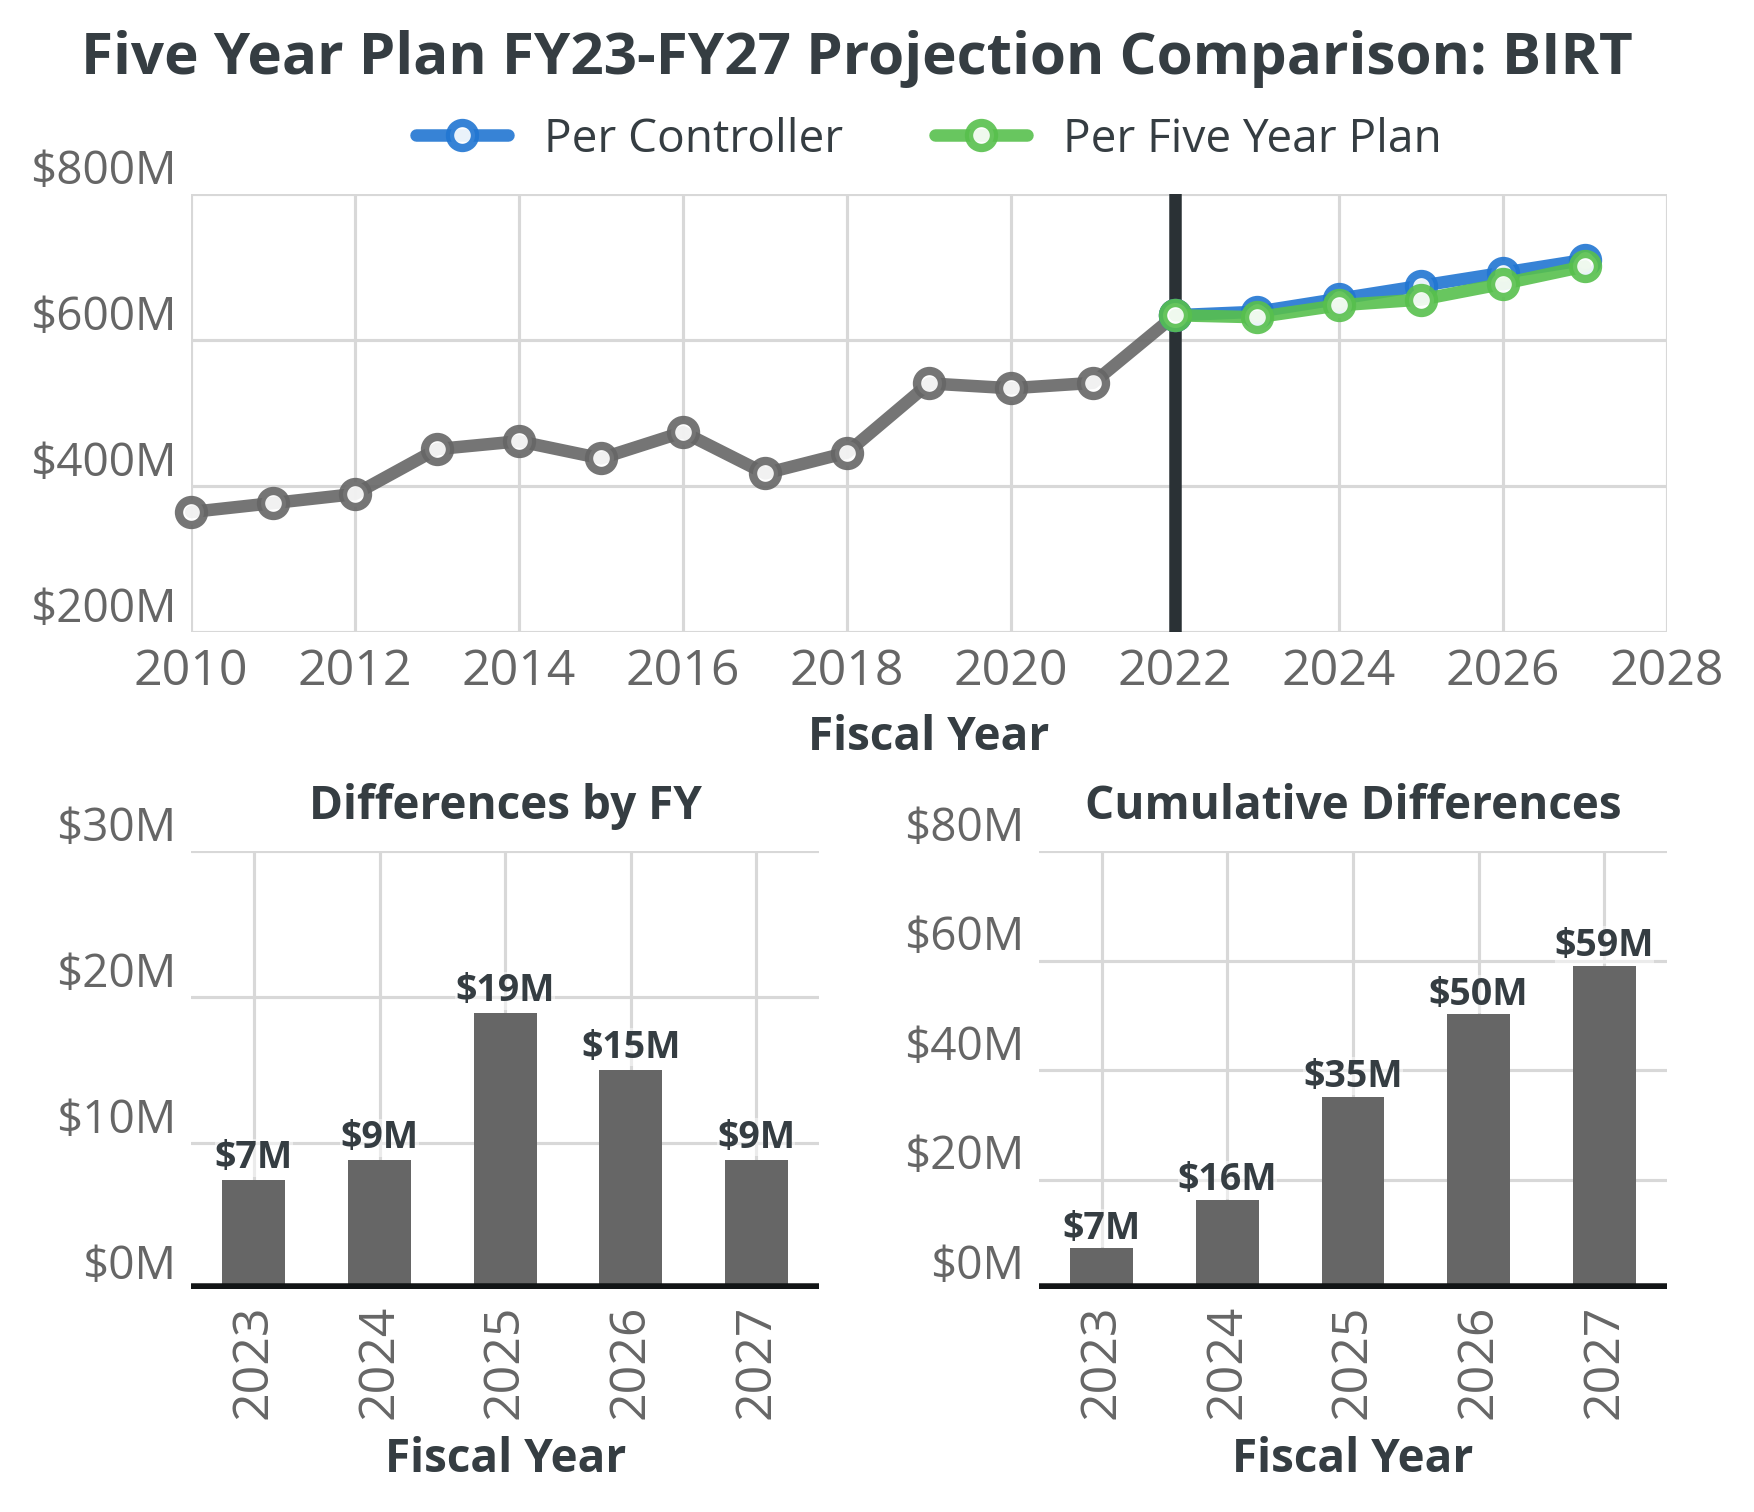

In [42]:
plot_projection_comparison(this_tax, forecast_gr_base, forecast_ni_base);